In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Acquire

In [91]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size', 'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [92]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


### Parse Datetime:

In [93]:
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [94]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


### Cleanup Text:

In [95]:

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


## Add Variable - Converting bytes to mb:

In [96]:
# convert bytes to mb
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [97]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [98]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [99]:
# drop the size column
df.drop(columns= 'size', inplace = True)

### Detecting Anomalies in Discrete Variables

#### Finding anomalies in already existing data:
- How many time a value of variable (e.g. ip address) shows up
- Calculate probability for each ip

In [100]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,52.90.165.200,1,0.000072
10,97.105.15.120,1,0.000072
11,95.31.16.121,1,0.000072
12,54.145.52.184,1,0.000072
13,52.91.30.150,1,0.000072


22
               ip  ip_count  ip_proba
0    97.105.19.58     11999  0.858420
1  173.173.113.51      1059  0.075762
2  72.181.113.170       613  0.043855
3   72.181.105.81       246  0.017599
4  68.201.219.223        21  0.001502
5     24.26.242.9        21  0.001502
6  35.175.171.137         2  0.000143
7   70.121.214.34         2  0.000143
8   52.87.230.102         2  0.000143
9   52.90.165.200         1  0.000072


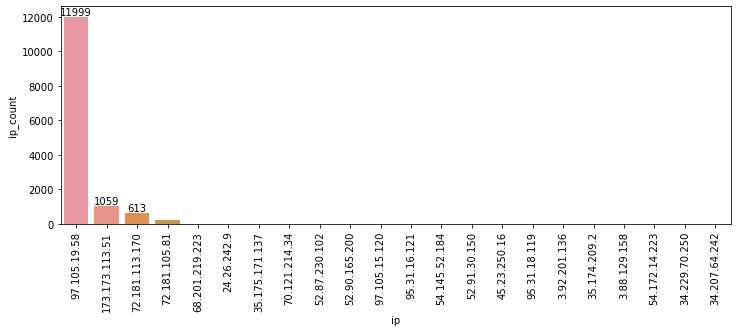

In [101]:
print(len(ip_df))

print(ip_df.head(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()-300), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.


#### Establish Baseline:

In [102]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','destination','request_agent','size_mb']]

In [103]:
train.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [104]:
# train size
train.size /df.size

0.9997138360280441

#### Compute probabilities based on train sample:

In [105]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [106]:
ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


#### Merge probabilities with all data (train + new data):

##### Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [107]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.tail(5)

,ip,request_method,status,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486532,0.858595
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.858595


### Conditional Probabilities: Probabilities using 2 discrete variables

#### Probability of Status given IP Address:

##### Conditional probability. Probability of A given B

##### prob(A|B) = prob(A & B) / prob(B)

In [108]:
# calculate prob for each ip in train 
ip_probs = train.groupby('ip').size().div(len(train))
ip_probs

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [109]:
ip_probs = train.groupby('ip').size().div(len(df))

# Conditional probability. Given an ip address, what is prob of a particular status
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_ip'})
                              )

status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [110]:
# calculate count for each combination of ip and status
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'ip_status_count'}))

# merge ip_status_count with status_given_ip dataframe

ip_status = status_given_ip.merge(ip_status_count)
ip_status.head()

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000286,1059
1,24.26.242.9,200,1.000286,21
2,3.88.129.158,200,1.000286,1
3,3.92.201.136,200,1.000286,1
4,34.207.64.242,200,1.000286,1


#### Add these probabilities to original events to detect anomalous events:

In [111]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

df.head()

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


In [ ]:
ip_status.proba

Text(0, 0.5, 'ip_proba')

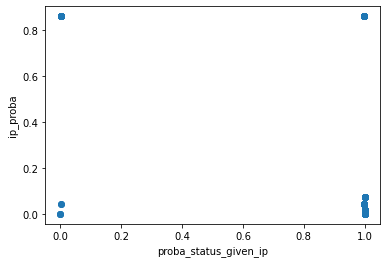

In [115]:
# plot the probabilities

plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.xlabel('proba_status_given_ip')
plt.ylabel('ip_proba')

In [113]:
df[(df['proba_status_given_ip'] < 0.2) & (df['ip_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.043867,0.003264,2.0
2019-04-17 03:42:44,72.181.113.170,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.043867,0.003264,2.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0
